# Preparing simulation data for ISOKANN
Date: 18.11.2025

In this notebook we prepare the simulation data into the required data structure for ISOKKAN.
With the new version of the ABM, where farms' initial capital are initialized randomly. 
We set the ABM opinion dynamics as majority rule, with group size 5

To estimate the chi functions ISOKANN requires two kinds of samples:
1. xs : starting points. It's 2-dimensional array of size = n_dim x n_samples. 
2. ys : propagated points. It is a 3-dimensional array of size = n_dim x n_koop x_samples.



Where n_dim = is the size of the state or feature state, n_samples is the total number of samples and n_koop is the number of Koopman-samples per starting point. Since we are working with time series, n_koop = 1. (For more information read:https://axsk.github.io/ISOKANN.jl/dev/introduction/ )


In [1]:
#import functions from src file
import os
import sys

# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.ABRam_BG_V01 import *

In [2]:
#Import necessary packages 
import pandas as pd
import numpy as np
import agentpy as ap
import matplotlib.pyplot as plt

# for CI 
from statsmodels.stats.proportion import proportion_confint


In [3]:
#We set the parameter values for the farms
alpha, delta, rho = 0.33, 0.05, 0.99
#Parameter such that farms investment is bigger that its capital depreciation, i.e I > delta K
Omega = (delta + (1/(rho*alpha)))**(1/(1 - alpha))
#Parameter such that farms investment is positive
omega = ((1-delta)/(alpha*rho))**(1/(1-alpha))
#Periods 
periods = 50

In [4]:
# Configuration with 5% green in the system
perc = 0.30

#Number of farms in the system
Farms = 100
green_farms = int(perc*Farms)
brown_farms = Farms - green_farms

#Total Initial capital in the systes
Tot_K0 = 10
Tot_G0 = perc*Tot_K0
Tot_B0 = Tot_K0 - Tot_G0

#Farms initial capital (Initially, they just own one type of capital)
frm_B0 = Tot_B0/brown_farms
frm_G0 = Tot_G0/green_farms

#Initial technical progress
gamma0 = Omega*frm_G0 + 1
beta0 = gamma0/perc

In [5]:
#We declare the dictionary of parameters for the simulation 
parameters = {
    'agents':Farms,
    'steps': periods,
    'delta': delta,
    'alpha': alpha,
    'rho': rho,
    'green_perc': perc,
    'Tot_K0': Tot_K0,

    'interaction': True, #False
    'opinion_dynamics': True,
    'interaction_type': 'MajorityRule',
    'interacting_farms':3,#[0,3,0,3,3,0,1],
    'network_topology': 'SW',
    'number_of_friends': 5,
    'network_randomness': 0.5,
    'time_steps_in_1_year':4,
    'seed':42,
    'draw_network':False, #For visualization draw initial and final network
    'emissions':False
}


# #We run the model 
# model = Economy(parameters)
# r_constant = model.run()

#Sample generation
# sample = ap.Sample(parameters, randomize=False)

# #We run 350 simulations for each social integration strategy
# exp = ap.Experiment(ABRam_BG.Economy, parameters, iterations=350, record=True) 
# voter_interactions = exp.run()

In [6]:
#Generating samples
exp_parameters = parameters.copy()

exp_parameters['green_perc'] = ap.Values(0.05,0.07,0.10,0.12,0.15,0.20,0.25,0.30,0.35,0.40)

sample = ap.Sample(exp_parameters)

In [8]:
#Run simulation with uniform sample size
sample_size = 400
#We run 400 simulations for each social integration strategy
exp = ap.Experiment(Economy, sample, iterations=sample_size, record=True) 
#Fix seed for reproducibility
exp.seed = 12345
#Run experiment
voter_interactions = exp.run()

Scheduled runs: 4000
Completed: 4000, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:06:23.450781


In [9]:
#Prepare data
FARMS =  voter_interactions.variables.Farm
#Computing green shares
STATS = voter_interactions.variables.Statistician
STATS['GOS'] = STATS.Total_P_G/STATS.GDP
STATS['GKS'] = STATS.Total_G/STATS.Total_K
STATS['G_farms'] = Farms - STATS.B_farms

In [10]:
#Proportion of green transitions per sample for all experiments and their CI lenght
# Access samples ids
samples_id = list(STATS.index.get_level_values(0).unique())
percentages = list(exp_parameters['green_perc'].values)

#set empty dict
samples_proportion = []
samples_CI_lenght = []
for i, sample_id in enumerate(samples_id):
    #print(f"sample no. {sample_id} - green:brown proportion {percentages[i]}")

    sample = STATS.loc[sample_id]
    #Access data at threshold period
    end_traj = sample.loc[:,:,periods-1]
    # Look for trajectories that reached a green economy
    successful_trajs = end_traj[end_traj['GOS'] >= 0.85]
    # count successfull trajectories
    num_successful_trajs = len(successful_trajs.index.get_level_values(0).unique())
    # compute proportion of successfull trajectories w.r.t. sample size
    proportion = num_successful_trajs/sample_size
    samples_proportion.append(proportion)
    #print(f"proportion = {proportion:.2f}")

    #We compute the confidence interval
    ci_pos = proportion + 1.96*np.sqrt((proportion*(1 - proportion))/sample_size)
    ci_neg = proportion - 1.96*np.sqrt((proportion*(1 - proportion))/sample_size)
    CI_voter = [ci_neg,ci_pos]
    print(f"CI = ({ci_pos:.3f}, {ci_neg:.3f})")
    lenght = ci_pos - ci_neg
    samples_CI_lenght.append(lenght)
    print(f"CI lenght ={lenght:.2f}")

    print(f"sample no. {sample_id} - green:brown proportion {percentages[i]}, proportion = {proportion:.2f}, CI = ({ci_pos:.3f}, {ci_neg:.3f}), CI lenght ={lenght:.2f}")


CI = (0.000, 0.000)
CI lenght =0.00
sample no. 0 - green:brown proportion 0.05, proportion = 0.00, CI = (0.000, 0.000), CI lenght =0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 1 - green:brown proportion 0.07, proportion = 0.00, CI = (0.000, 0.000), CI lenght =0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 2 - green:brown proportion 0.1, proportion = 0.00, CI = (0.000, 0.000), CI lenght =0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 3 - green:brown proportion 0.12, proportion = 0.00, CI = (0.000, 0.000), CI lenght =0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 4 - green:brown proportion 0.15, proportion = 0.00, CI = (0.000, 0.000), CI lenght =0.00
CI = (0.000, 0.000)
CI lenght =0.00
sample no. 5 - green:brown proportion 0.2, proportion = 0.00, CI = (0.000, 0.000), CI lenght =0.00
CI = (0.012, -0.002)
CI lenght =0.01
sample no. 6 - green:brown proportion 0.25, proportion = 0.01, CI = (0.012, -0.002), CI lenght =0.01
CI = (0.101, 0.049)
CI lenght =0.05
sample no. 7

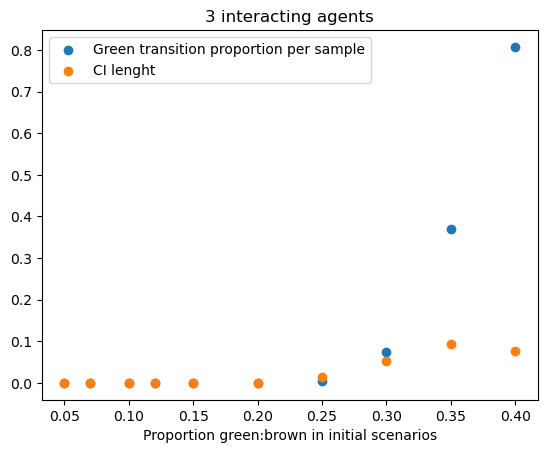

In [11]:
#Scatter plot
percentages
samples_proportion 
plt.scatter(percentages, samples_proportion, label= "Green transition proportion per sample")
plt.scatter(percentages, samples_CI_lenght, label="CI lenght")
plt.xlabel("Proportion green:brown in initial scenarios")
plt.title("3 interacting agents")
plt.legend()
plt.show()

In [12]:
#initialize list
samples_proportion = []
samples_CI_lenght_CP = []

#Loop through samples
for i, sample_id in enumerate(samples_id):
    sample = STATS.loc[sample_id]
    end_traj = sample.loc[:,:,periods-1]

    #Count successful trajectories
    successful_trajs = end_traj[end_traj['GOS'] >= 0.85]
    num_successful_trajs = len(successful_trajs.index.get_level_values(0).unique())


    #compute proportion
    proportion = num_successful_trajs/sample_size
    samples_proportion.append(proportion)

    #Compute Clopper-Pearson exact 95% CI
    ci_low, ci_upp = proportion_confint(count=num_successful_trajs,
                                        nobs=sample_size,
                                        alpha=0.05,
                                        method='beta')
    
    #Store CI length
    ci_length = ci_upp - ci_low
    samples_CI_lenght_CP.append(ci_length)

    print(f'{sample_id}) green-to-brown ratio = {percentages[i]}, proportion={proportion:.3f}, CI = ({ci_low:.3f}, {ci_upp:.3f}), lenght={ci_length:.3f}')

0) green-to-brown ratio = 0.05, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
1) green-to-brown ratio = 0.07, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
2) green-to-brown ratio = 0.1, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
3) green-to-brown ratio = 0.12, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
4) green-to-brown ratio = 0.15, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
5) green-to-brown ratio = 0.2, proportion=0.000, CI = (0.000, 0.009), lenght=0.009
6) green-to-brown ratio = 0.25, proportion=0.005, CI = (0.001, 0.018), lenght=0.017
7) green-to-brown ratio = 0.3, proportion=0.075, CI = (0.051, 0.105), lenght=0.054
8) green-to-brown ratio = 0.35, proportion=0.370, CI = (0.323, 0.419), lenght=0.097
9) green-to-brown ratio = 0.4, proportion=0.807, CI = (0.765, 0.845), lenght=0.080


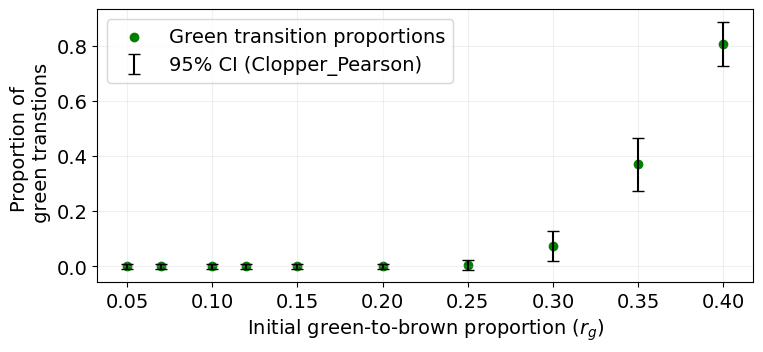

In [16]:
plt.rcParams['font.size'] = 14

#Compute half-lengths of CI for errorbar plotting
ci_half = np.array(samples_CI_lenght_CP)

fig, ax = plt.subplots(figsize= (215/25.4, 180/(2*25.4),))

#Scatter points for the proportions
plt.scatter(percentages, samples_proportion, color= 'green', label='Green transition proportions')

#add CI bars
plt.errorbar(
    percentages,
    samples_proportion,
    yerr=ci_half,
    fmt='none',
    ecolor='black',
    capsize=4,
    label='95% CI (Clopper_Pearson)'
)

#Labels and title
plt.xlabel('Initial green-to-brown proportion'+r' ($r_g$)')
plt.ylabel('Proportion of \n green transtions')
plt.grid(alpha=0.2)
plt.legend()

#Create results directory
path = os.path.join('ABa-KiTo', 'majority_rule', 'data')
data_dir = os.path.join(project_root, path)

graphs_dir = os.path.join(data_dir, 'graphs_results')
os.makedirs(graphs_dir, exist_ok=True)
results_dir = graphs_dir

plt.savefig(f"{results_dir}/proportion_of_green_transitions_and_CI_length_MR.pdf", bbox_inches = 'tight')

In [13]:
#Microvariables
#Select microvariables we are interested
production = FARMS[['P_B', 'P_G']]
#shape data as  production vectors
productions = production.stack(level=-1)
#starting points from t=[0:periods-1]
xs = productions.loc[:,:,:,:periods-1]
xs_farms = xs.unstack(level=0).unstack(level=0).unstack(level=1)
xs_farms = xs_farms.to_numpy()

#propagation points from t= [1:periods]
ys = productions.loc[:,:,:,1:]
ys_farms = ys.unstack(level=0).unstack(level=0).unstack(level=1)
ys_farms = ys_farms.to_numpy()

In [14]:
#Macrovariables
macro_var = STATS[['G_farms', 'GOS']]
macro_var = macro_var.stack(level=-1)
#starting points from t=[0:periods-1]
xs_macro = macro_var.loc[:,:,:,:periods-1]
xs_macro = xs_macro.unstack(level=0).unstack(level=0).unstack(level=1)
xs_macro = xs_macro.to_numpy()

#Propagating points from t=[1:periods]
ys_macro = macro_var.loc[:,:,:,1:]
ys_macro = ys_macro.unstack(level=0).unstack(level=0).unstack(level=1)
ys_macro = ys_macro.to_numpy()

In [15]:
#construct data structures
#Construct starting points
xs = np.vstack((xs_farms, xs_macro))
#Construct propagating points
ys = np.vstack((ys_farms, ys_macro))

In [16]:
#Check if the shape of both are the same
xs.shape == ys.shape

True

In [17]:
#reshape ys to the required structure for ISOKANN
ndim, nsample = ys.shape[0], ys.shape[1]

ys = ys.reshape(ndim, 1, nsample) 

In [18]:
#save data to get them into Julia

# Create the path and ensure the directory exists for saving the data
data_dir = os.path.join( "..", 'data', 'simulations')
os.makedirs(data_dir, exist_ok=True)

# Build full path
file_path = os.path.join(data_dir, "2025-11-18-data_majority_rule.npz")

# Save xs and ys in the same file
np.savez(file_path, xs=xs, ys=ys)

In [7]:
# New simulations for validation and correlation analysis
#Generating samples
exp_validation = exp_parameters.copy()

exp_validation['see'] = 24

sample = ap.Sample(exp_validation)

In [23]:
#Run simulation with uniform sample size for validation
sample_size = 400
#We run 400 simulations for each social integration strategy
exp = ap.Experiment(Economy, sample, iterations=sample_size, record=True) 
#Fix seed for reproducibility
exp.seed = 42
#Run experiment
voter_interactions = exp.run()

Scheduled runs: 4000
Completed: 4000, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:06:19.058652


In [24]:
#Prepare data
FARMS =  voter_interactions.variables.Farm
#Computing green shares
STATS = voter_interactions.variables.Statistician
STATS['GOS'] = STATS.Total_P_G/STATS.GDP
STATS['GKS'] = STATS.Total_G/STATS.Total_K
STATS['G_farms'] = Farms - STATS.B_farms

In [25]:
#Microvariables
#Select microvariables we are interested
production = FARMS[['P_B', 'P_G']]
#shape data as  production vectors
productions = production.stack(level=-1)
#starting points from t=[0:periods-1]
xs = productions.loc[:,:,:,:periods-1]
xs_farms = xs.unstack(level=0).unstack(level=0).unstack(level=1)
xs_farms = xs_farms.to_numpy()

#propagation points from t= [1:periods]
ys = productions.loc[:,:,:,1:]
ys_farms = ys.unstack(level=0).unstack(level=0).unstack(level=1)
ys_farms = ys_farms.to_numpy()

In [26]:
#STATS for correlation analysis
#Macrovariables
macro_vars = STATS
macro_vars = macro_vars.stack(level=-1)
#starting points from t=[0:periods-1]
xs_corr = macro_vars.loc[:,:,:,:periods-1]
xs_corr = xs_corr.unstack(level=0).unstack(level=0).unstack(level=1)
xs_corr = xs_corr.to_numpy()

#construct data structures
#Construct starting points
xs_corr = np.vstack((xs_farms, xs_corr))

# Build full path
# Create the path and ensure the directory exists for saving the data
data_dir = os.path.join( "..", 'data', 'simulations')
os.makedirs(data_dir, exist_ok=True)
file_path = os.path.join(data_dir, "2025-11-26-dataCorrelation_majority_rule.npz")

# Save xs and ys in the same file
np.savez(file_path, xs=xs_corr)

In [22]:
xs_corr.shape

(212, 200000)

In [32]:
STATS.columns.values

array(['Total_G', 'Total_B', 'Total_K', 'real_beta', 'real_gamma', 'GDP',
       'Total_P_G', 'Total_P_B', 'B_farms', 'GOS', 'GKS', 'G_farms'],
      dtype=object)

In [33]:
cols_name_path = os.path.join(data_dir, "2025-11-26_macro_vars_names.npz")

cols = np.array(STATS.columns, dtype=str)   # forces dtype='<U...'

np.savez(cols_name_path, macro_vars_names=cols)

